In [24]:
%matplotlib inline
import numpy as np
# import pysal as ps
# import random as rdm
# import geopandas as gpd
import matplotlib.pyplot as plt
# import os
# import json
# import geojson as gj
# import folium as fl
# from pysal.contrib.viz import folium_mapping as fm
# from pylab import rcParams
# rcParams['figure.figsize'] = 20,20

from database_manager import DatabaseManager
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist
from sklearn.preprocessing import scale

In [75]:
NUM_ZILLOW_ZIPS = 297
NUM_DEMOGRAPHIC_ZIPS = 404

############################################
# CHANGE THIS WHEN YOU ADD/REMOVE FEATURES #
############################################
NUM_FEATURES_DEM = 22
NUM_FEATURES_ZILLOW = 5

def create_connection():
    conn = DatabaseManager.get_connection()
    cursor = conn.cursor(buffered=True)
    return conn, cursor

def close_connection(conn, cursor):
    cursor.close()
    conn.close()
    
## Pulls in the demographic features 
def get_demographics(conn, cursor):
    feature_dict = {}
    cursor.execute("SELECT zip_id, personal_vehicle, carpool, public_transportation, taxi, motorcycle, walking, bicycle FROM transportation_method, zip WHERE transportation_method.zip_id=zip.id")
    rows = cursor.fetchall()
    list_ind = 0
    
    for row in rows:
        for ind, val in enumerate(row):
            if row[0] not in feature_dict:
                feature_dict[row[0]] = np.zeros(NUM_FEATURES_DEM)
            if ind > 0:
                feature_dict[row[0]][ind-1] = val
        
    list_ind = ind
    
    cursor.execute("SELECT zip_id, recipient_count FROM food_stamps, zip WHERE food_stamps.zip_id=zip.id")
    rows = cursor.fetchall()
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
        
    cursor.execute("SELECT zip_id, median_income FROM median_income, zip WHERE median_income.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
        
    cursor.execute("SELECT zip_id, population FROM total_population, zip WHERE total_population.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
    
    cursor.execute("SELECT zip_id, family_households, nonfamily_households FROM relationships, zip WHERE relationships.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
    
    cursor.execute("SELECT zip_id, less_than_high_school, bachelors, masters FROM education, zip WHERE education.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
    
    cursor.execute("SELECT zip_id, male, female, percent_white, percent_black, percent_asian FROM age_race_sex, zip WHERE age_race_sex.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
    
    cursor.execute("SELECT zip_id, english_only, non_english FROM language_spoken, zip WHERE language_spoken.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
    
    return feature_dict


# Pulls in Zillow data
def get_zillow_data(conn, cursor):
    feature_dict = {}
    cursor.execute("SELECT zip_code, median_listing_price, median_listing_price_per_sqft, inventory, percent_increase, percent_decrease FROM la_zillow_data;")
    rows = cursor.fetchall()
    list_ind = 0
    
    for row in rows:
        for ind, val in enumerate(row):
            if row[0] not in feature_dict:
                feature_dict[row[0]] = np.zeros(NUM_FEATURES_ZILLOW)
            if ind > 0:
                feature_dict[row[0]][ind-1] = val
                
    return feature_dict

Import data

Import ACS data from csv, set geoid as the index, and drop non-included variables

In [ ]:
la_acs = pd.csv(la_acs.csv)
la_acs = la_acs.rename(index=str, columns={'GEO.id':'geoid', acs_est_name:'est', acs_moe_name:'moe'})
la_acs.set_index(la_acs.geoid, inplace=True)
la_acs = la_acs.drop('geoid', axis=1)

In [ ]:
la_geog = gpd.read_file('CAMS_ZIPCODE_STREET_SPECIFIC/CAMS_ZIPCODE_STREET_SPECIFIC.shp')
la_geog['constant'] = 1
p = la_geog.plot(color='green', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()

In [76]:
## Create a connection to the db
conn, cursor = create_connection()

## Pull in the demographic features
feature_dict_dem = get_demographics(conn, cursor)

## Pull in the zillow data
feature_dict_zillow = get_zillow_data(conn, cursor)

## Feature_dict should be {zip_id: [list of x features]},
## so let's print out an example to make sure
print(feature_dict_dem[19607])
print(feature_dict_zillow["90802"])

[ 181.     0.   181.     0.     4.     5.     1.   217.   217.   417.    95.
   25.    68.    67.    80.   220.   197.    96.9    1.     1.   392.    15. ]
[  4.12125000e+05   4.12125000e+05   7.96667000e+01   8.16991670e+01
   1.37616670e+01]


In [77]:
## Create a readable feature-vector from the values using np
X_dem = np.zeros((NUM_DEMOGRAPHIC_ZIPS, NUM_FEATURES_DEM))
for ind, (k,v) in enumerate(feature_dict_dem.items()):
    X_dem[ind] = v

X_zillow = np.zeros((NUM_ZILLOW_ZIPS, NUM_FEATURES_ZILLOW))
for ind, (k,v) in enumerate(feature_dict_zillow.items()):
    X_zillow[ind] = v

scale(X_zillow)
close_connection(conn, cursor)

Text(0.5,1,'Finding the AIC and BIC for Demographic Data')

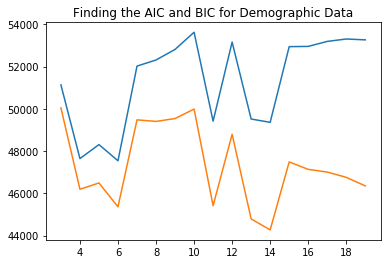

In [12]:
k_vals = np.arange(3, 20)
models = [GaussianMixture(k, random_state = 1234).fit(X_dem) for k in k_vals]

plt.plot(k_vals, [m.bic(X_dem) for m in models], label = 'BIC')
plt.plot(k_vals, [m.aic(X_dem) for m in models], label = 'AIC')
plt.title('Finding the AIC and BIC for Demographic Data')


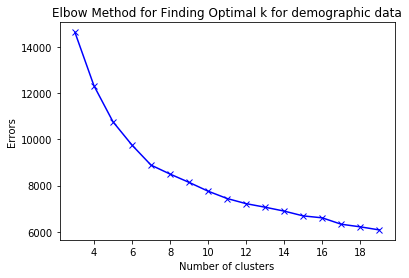

In [78]:
errors = []
k_vals = np.arange(3, 20)
for k in k_vals:
    kmeans_model = KMeans(n_clusters = k, init = 'k-means++').fit(X_dem)
    errors.append(sum(np.min(cdist(X_dem, kmeans_model.cluster_centers_, 'euclidean'), axis=1))/X_dem.shape[0])
    
plt.plot(k_vals, errors, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Errors')
plt.title('Elbow Method for Finding Optimal k for demographic data')
plt.show()

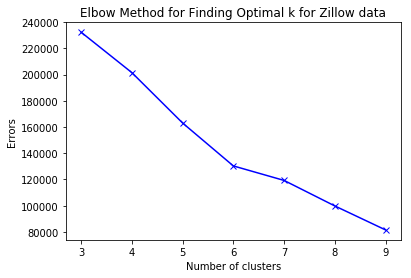

In [79]:
errors = []
k_vals = np.arange(3, 10)
for k in k_vals:
    kmeans_model = KMeans(n_clusters = k, init = 'k-means++').fit(X_zillow)
    errors.append(sum(np.min(cdist(X_zillow, kmeans_model.cluster_centers_, 'euclidean'), axis=1))/X_zillow.shape[0])
    
plt.plot(k_vals, errors, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Errors')
plt.title('Elbow Method for Finding Optimal k for Zillow data')
plt.show()

In [70]:
# k_vals = np.arange(2, 3)
# models = [GaussianMixture(k, random_state = 1234).fit(X_zillow) for k in k_vals]

# plt.title('Find AIC and BIC for Zillow data')
# plt.plot(k_vals, [m.bic(X) for m in models], label = 'BIC')
# plt.plot(k_vals, [m.aic(X) for m in models], label = 'AIC')

In [51]:
clusterer_k = KMeans(n_clusters=7, init = 'k-means++', random_state=1234)
cluster_labels_k = clusterer_k.fit_predict(X_dem)

clusterer_GMM = GaussianMixture(11, random_state = 1234)
cluster_labels_gmm = clusterer_GMM.fit(X_dem)

In [ ]:
la_geog['cluster_k'] = cluster_labels_k
p = la_geog.plot(column='cluster_k', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()

In [ ]:
la_geog['cluster_gmm'] = cluster_labels_gmm
p = la_geog.plot(column='cluster_gmm', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()

In [64]:
clusterer_k_zillow = KMeans(n_clusters=4, init = 'k-means++', random_state=1234)
cluster_labels_k_zillow = clusterer_k_zillow.fit_predict(X_zillow)

# clusterer_GMM = GaussianMixture(2, random_state = 1234)
# cluster_labels_gmm = clusterer_GMM.fit(X_zillow)

In [ ]:
la_geog['cluster_k'] = cluster_labels_k_zillow
p = la_geog.plot(column='cluster_k', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()

In [ ]:
# la_geog['cluster_gmm'] = cluster_labels_gmm
# p = la_geog.plot(column='cluster_gmm', linewidth=0.5, edgecolor='white')
# p.axis('off')
# p.plot()

In [65]:
print(np.mean(clusterer_k.cluster_centers_, axis=1))
print(np.mean(clusterer_k_zillow.cluster_centers_, axis=1))

[  403861.3015392   1071135.8939634    166398.12731788  2198224.6291602
   262948.21880821  1421744.09704335   657189.38738667]
[  215391.83330933   824875.59234617  1577040.20346672   406251.51522597]
